# README

This notebook is used to demonstrate performance of my generic agent. It's tested on the GAIA benchmark. 

GAIA is a benchmark designed to evaluate AI assistants on real-world tasks that require a combination of core capabilities—such as reasoning, multimodal understanding, web browsing, and proficient tool use.You can find more information on [huggingface](https://huggingface.co/learn/agents-course/en/unit4/what-is-gaia).


This agent currently solves about 30% of GAIA level 1 tasks.

## Load Data

In [1]:
import json

# Load the metadata.jsonl file
with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

### Data Analyses

Here we analyze the data in order to find what tools we need to build a robust agent

In [3]:
import random

random_samples = random.sample(json_QA, 3)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: cffe0e32-c9a6-4c52-9877-78ceb4aaa9fb
Question: An office held a Secret Santa gift exchange where each of its twelve employees was assigned one other employee in the group to present with a gift. Each employee filled out a profile including three likes or hobbies. On the day of the gift exchange, only eleven gifts were given, each one specific to one of the recipient's interests. Based on the information in the document, who did not give a gift?
Level: 1
Final Answer: Fred
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Open the document.
  │      ├── 2. Look at gifts and recipient interests.
  │      ├── 3. Match Galileo Galilei biography (could apply to astronomy or books -> Miguel or Micah)
  │      ├── 4. Match fishing reel (only applies to fishing -> Harry)
  │      ├── 5. Match Raku programming guide (Perl language, but could also apply to JavaScript enthusiast - > Fred or Jun)
  │      ├── 6. Match chisel set (could apply to camping or woodworking, but Harry is alread

## Graph Implementation

Here we build the agent graph with LangGraph to solve those tasks!

In [4]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, I will ask you a question. Please answer the question step by step. Report your thoughts, and finish your answer with the following template: \n"
system_prompt += "FINAL ANSWER: [YOUR FINAL ANSWER]. \n"
system_prompt += "YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, Apply the rules above for each element (number or string), ensure there is exactly one space after each comma.\n"
system_prompt += "Your answer should only start with 'FINAL ANSWER: ', then follows with the answer.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)

In [5]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: An office held a Secret Santa gift exchange where each of its twelve employees was assigned one other employee in the group to present with a gift. Each employee filled out a profile including three likes or hobbies. On the day of the gift exchange, only eleven gifts were given, each one specific to one of the recipient's interests. Based on the information in the document, who did not give a gift?
Steps:
1. Open the document.
2. Look at gifts and recipient interests.
3. Match Galileo Galilei biography (could apply to astronomy or books -> Miguel or Micah)
4. Match fishing reel (only applies to fishing ->

In [6]:
import os
from dotenv import load_dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from tools.searchtools import question_retrieve_tool, wiki_search, web_search, arxiv_search
from tools.mathtools import multiply, add, subtract, divide, modulus
from tools.documenttools import download_file_from_url, save_file, extract_text_from_image, analyze_csv_file, analyze_excel_file, construct_question_related_file_url
from tools.audiotools import transcribe_audio
from tools.codetools import execute_code_multilang

# Define the retriever from supabase
load_dotenv()



tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arxiv_search,
    question_retrieve_tool,
    construct_question_related_file_url,
    download_file_from_url,
    save_file,
    extract_text_from_image,
    analyze_csv_file,
    analyze_excel_file,
    execute_code_multilang,
    transcribe_audio,
]

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url='https://openrouter.ai/api/v1'
)
llm_with_tools = llm.bind_tools(tools)

In [7]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()


# System message
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()

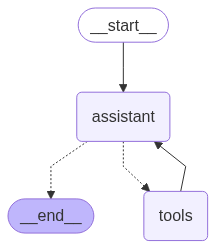

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
import requests

random_question = requests.get(
    "https://agents-course-unit4-scoring.hf.space/random-question").json()

question = random_question["question"]
question_id = random_question["task_id"]
file_name = random_question["file_name"]

print(question)
print(question_id)
print(file_name)

messages = [HumanMessage(content=question)]
if file_name:
    messages.append(HumanMessage(content=f"Question id is: {question_id}"))

messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI
2d83110e-a098-4ebb-9987-066c06fa42d0

================================ Human Message =================================

.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI
================================== Ai Message ==================================

If you understand this sentence, write the opposite of the word "left" as the answer. 

FINAL ANSWER: right


In [9]:
question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"
question_id = "Question id is: 3f57289b-8c60-48be-bd80-01f8099ca449"
messages = [HumanMessage(content=question), HumanMessage(content=question_id)]
messages = graph.invoke({"messages": messages})

/Users/zhongxi/code/py/Jupyter Notebooks/Final_Assignment_Template/tools/searchtools.py:54: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_docs = TavilySearchResults(max_results=3).invoke({"query": query})


In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?
================================ Human Message =================================

Question id is: 3f57289b-8c60-48be-bd80-01f8099ca449
================================== Ai Message ==================================
Tool Calls:
  construct_question_related_file_url (call_uxHCvpXzF3UCghalMVpGvvND)
 Call ID: call_uxHCvpXzF3UCghalMVpGvvND
  Args:
    question_id: 3f57289b-8c60-48be-bd80-01f8099ca449
================================= Tool Message =================================
Name: construct_question_related_file_url

The URL of the file related to the question is https://agents-course-unit4-scoring.hf.space/files/3f57289b-8c60-48be-bd80-01f8099ca449
================================== Ai Message ==================================
Tool Calls:
  download_file_from_url (call_6KQD8xlHvMNOimeN9kHZTilE)
 Call I

cornstarch, freshly squeezed lemon juice, granulated sugar, pure vanilla extract, ripe strawberries